In [1]:
import matplotlib.pyplot as plt
import os 
import drjit as dr
import mitsuba as mi
import random
import numpy as np

mi.set_variant('cuda_ad_rgb')

In [2]:
sensor_count = 1
sensor = {
    'type': 'batch',
    'film': {
        'type': 'hdrfilm',
        'width': 512 * sensor_count, 'height': 512,
        'filter': {'type': 'gaussian'},
        'sample_border': True
    }
}

In [3]:
from mitsuba import ScalarTransform4f as T
heightfield_ref = {
        'type': 'heightfield',
        'filename': 'data/depth.bmp',
        'max_height': 1.0,
        'bsdf': {
            'type': 'diffuse',
            'reflectance': {
                'type': 'rgb',
                'value': [0.5, 0.5, 0.5]
            }
          },
        'to_world': T.translate(mi.ScalarPoint3f(0.0, -0.4, 0.0)) @ T.rotate(mi.ScalarPoint3f(1.0, 0.0, 0.0), (-90)) @ T.scale(mi.ScalarPoint3f(0.5, 0.5, 0.5))
        }

In [4]:
heightfield_src = {
        'type': 'heightfield',
        'resolution' : 200,
        'max_height': 1.0,
        'bsdf': {
            'type': 'diffuse',
            'reflectance': {
                'type': 'rgb',
                'value': [0.5, 0.5, 0.5]
            }
          },
        'to_world': T.translate(mi.ScalarPoint3f(0.0, -0.4, 0.0)) @ T.rotate(mi.ScalarPoint3f(1.0, 0.0, 0.0), (-90)) @ T.scale(mi.ScalarPoint3f(0.5, 0.5, 0.5))
        }

In [5]:
import numpy as np 
def generate_points_circle(r, amount, height):
    return [mi.ScalarPoint3f(np.cos(2*np.pi/amount*x)*r, np.sin(2*np.pi/amount*x)*r, height) for x in range(0,amount + 1)]   

In [6]:
spot_light_1 = {'type': 'spot',
                'to_world': mi.ScalarTransform4f.look_at(
                    origin=[-1.0, 0.05, -0.25],
                    target=[0, -0.2, 0],
                    up=[0, 1, 0]
                ),
                'intensity': {
                    'type': 'spectrum',
                    'value': 10.0,
                }
            }

In [7]:
spot_light_2 = {'type': 'spot',
                'to_world': mi.ScalarTransform4f.look_at(
                    origin=[0.9, -0.15, -0.25],
                    target=[0, 0, 0],
                    up=[0, 1, 0]
                ),
                'intensity': {
                    'type': 'spectrum',
                    'value': 10.0,
                }
            }

In [8]:
spot_light_3 = {'type': 'sphere',
'to_world': mi.ScalarTransform4f.look_at(
                    origin=[0.0, -0.7, 5],
                    target=[0, 0, 0],
                    up=[0, 1, 0]
                ) @ mi.ScalarTransform4f.scale(0.01),
'emitter': {
    'type': 'area',
    'radiance': {
        'type': 'rgb',
        'value': 50000.0,
    }
}
}

In [9]:
def update(pi, params, key):
    params[key] *= (1 + pi)    
    params.update()

In [10]:
def render_fd_gradient_img(src_scene, params, iteration):
    Δ = 5e-4
    fd_integrator = mi.load_dict({"type": "path"})
    fd_spp = 1024
    fd_repeat = 128
    img1 = dr.zeros(mi.TensorXf, (256, 256, 3))
    img2 = dr.zeros(mi.TensorXf, (256, 256, 3))
    for it in range(fd_repeat):
        update(-Δ, params, 'heightfield.heightfield')
        img1 += mi.render(src_scene, sensor=0, integrator=fd_integrator, spp=fd_spp, seed=it)
        update(+Δ, params, 'heightfield.heightfield')
        img2 += mi.render(src_scene, sensor=0, integrator=fd_integrator, spp=fd_spp, seed=it)
        print(f"{it+1}/{fd_repeat}", end='\r')
    fd_img = (img2 - img1) / (Δ*2) / fd_repeat
    mi.util.write_bitmap(f"output/gradients/fd/gradient_img_fd_{iteration}.exr", fd_img)


In [11]:
import gc
def render_reparam_gradient_img(src_scene, params, iteration):
    key = "heightfield.heightfield"
    init_state = type(params[key])(params[key])
    reparam_integrator = mi.load_dict({"type": "prb_reparam"})

    res = src_scene.sensors()[0].film().size()
    fwd_img = dr.zeros(mi.TensorXf, (res[0], res[1], 3))
    mine_repeat = 1
    for it in range(mine_repeat):
        π = mi.Float(0.0)
        dr.enable_grad(π)
        update(π, params, key)
        dr.forward(π, dr.ADFlag.ClearEdges)

        image = mi.render(src_scene, params=params, sensor=0, integrator=reparam_integrator, seed=it)
        fwd_img += dr.forward_to(image)
        del image
        gc.collect()
        print(f"{it+1}/{mine_repeat}", end='\r')
    fwd_img /= float(mine_repeat)
    mi.util.write_bitmap(f"output/gradients/reparam/gradient_img_reparam_{iteration}.exr", fwd_img)

In [12]:
from mitsuba import ScalarTransform4f as T

scene_dict = mi.cornell_box()
del scene_dict['small-box']
del scene_dict['large-box']
scene_dict['sensor']['film']['sample_border'] = True
scene_dict['sensor']['film']['width'] = 256
scene_dict['sensor']['film']['height'] = 256

scene_dict['integrator'] = { 'type': 'prb_reparam',
                             'max_depth': 8,
                             'reparam_rays': 8 } 
scene_dict['light']['to_world'] @= T.scale(mi.ScalarPoint3f(3.0, 3.0, 3.0))
scene_dict['light']['emitter']['radiance']['value'] = mi.ScalarPoint3f(3, 3, 2)
scene_dict['light2'] = spot_light_1
scene_dict['light3'] = spot_light_2
scene_dict['light4'] = spot_light_3

scene_dict['heightfield'] = heightfield_ref
scene_ref = mi.load_dict(scene_dict)

In [13]:
def plot_batch_output(out: mi.TensorXf):
    fig, ax = plt.subplots(figsize=(5*sensor_count, 5))
    ax.imshow(mi.util.convert_to_bitmap(out))
    ax.axis('off')

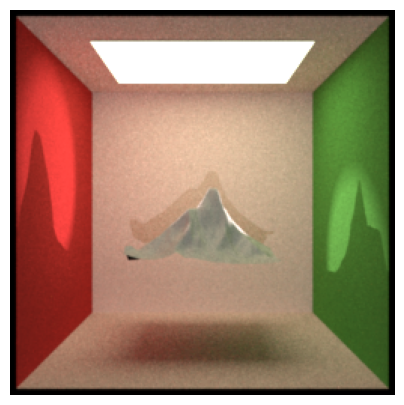

In [14]:
ref_img = mi.render(scene_ref, spp=256)
plot_batch_output(ref_img)

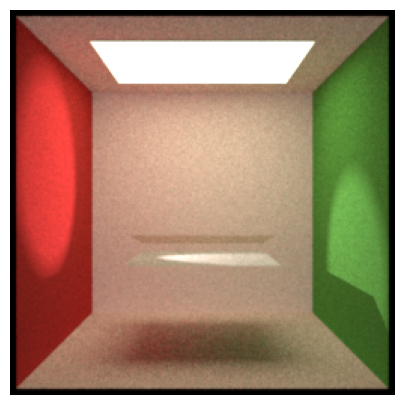

In [15]:
scene_dict['heightfield'] = heightfield_src
scene_source = mi.load_dict(scene_dict)

init_img = mi.render(scene_source, spp=128)
plot_batch_output(init_img)

In [16]:
params = mi.traverse(scene_source)
res_x = params['heightfield.res_x']
res_y = params['heightfield.res_y']

In [17]:
# params_ref = mi.traverse(scene_ref)
# render_fd_gradient_img(scene_ref, params_ref, 0)
# render_reparam_gradient_img(scene_ref, params_ref, 0)

In [18]:
def init_optimizer(lambda_, learning_rate = 0.1):
    ls = mi.ad.LargeSteps(params['heightfield.heightfield'], lambda_)
    opt = mi.ad.Adam(lr=learning_rate, uniform=True)
    opt['u'] = ls.to_differential(dr.clamp(params['heightfield.heightfield'], 0.0, 1.0), True)
    return ls, opt

In [19]:
iterations = 200
# upsampling_steps = [10, 30, 40, 50, 60]
upsampling_steps = [30, 60, 100, 150]

In [20]:
lambda_ = 20
ls, opt = init_optimizer(lambda_, 0.1)

In [21]:
for it in range(iterations):
    loss = mi.Float(0.0)
    
    if it in upsampling_steps:
        lambda_ += 2
        ls, opt = init_optimizer(lambda_, 0.8 * opt.lr['u'])

    # Retrieve the vertex positions from the latent variable
    t = dr.unravel(mi.Point3f, ls.from_differential(opt['u']))
    params['heightfield.heightfield'] = mi.TensorXf(t.z, (res_x,res_y,1))
    params.update()

    img = mi.render(scene_source, params, seed=it, spp=128)
    mi.util.write_bitmap(f"output/cornell/iteration_{it}.png", img)
    
    # L1 Loss
    loss = dr.mean(dr.abs(img - ref_img))
    dr.backward(loss)
    opt.step()

    print(f"Iteration {1+it:03d}: Loss = {loss[0]:6f}", end='\r')

In [ ]:
# Update the mesh after the last iteration's gradient step
t = dr.unravel(mi.Point3f, ls.from_differential(opt['u']))
params['heightfield.heightfield'] = mi.TensorXf(t.z, (res_x,res_y,1))
params.update()